<a href="https://colab.research.google.com/github/sa21262/datascience22/blob/main/lab3/Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import itertools

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.dummy import DummyRegressor, DummyClassifier

In [22]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/ce888/master/lab3/dataset_Facebook.csv", delimiter=";")
df

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,85093,Photo,3,1,7,2,0.0,4684,7536,733,708,985,4750,2876,392,5,53.0,26.0,84
496,81370,Photo,2,1,5,8,0.0,3480,6229,537,508,687,3961,2104,301,0,53.0,22.0,75
497,81370,Photo,1,1,5,2,0.0,3778,7216,625,572,795,4742,2388,363,4,93.0,18.0,115
498,81370,Photo,3,1,4,11,0.0,4156,7564,626,574,832,4534,2452,370,7,91.0,38.0,136


In [23]:
df.info() # gives information about type and no NaN rows of the data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Page total likes                                                     500 non-null    int64  
 1   Type                                                                 500 non-null    object 
 2   Category                                                             500 non-null    int64  
 3   Post Month                                                           500 non-null    int64  
 4   Post Weekday                                                         500 non-null    int64  
 5   Post Hour                                                            500 non-null    int64  
 6   Paid                                                                 499 non-null    float64
 7   Lifetime

In [24]:
df['Type'].value_counts() # gives information about each category in object type column 

Photo     426
Status     45
Link       22
Video       7
Name: Type, dtype: int64

In [25]:
df.describe() # returns statictical values about the data 

,Page total likes,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
count,500.000000,500.000000,500.000000,500.000000,500.000000,499.000000,500.00000,5.000000e+02,500.000000,500.000000,500.000000,5.000000e+02,500.000000,500.000000,500.00000,499.000000,496.000000,500.000000
mean,123194.176000,1.880000,7.038000,4.150000,7.840000,0.278557,13903.36000,2.958595e+04,920.344000,798.772000,1415.130000,1.676638e+04,6585.488000,609.986000,7.48200,177.945892,27.266129,212.120000
std,16272.813214,0.852675,3.307936,2.030701,4.368589,0.448739,22740.78789,7.680325e+04,985.016636,882.505013,2000.594118,5.979102e+04,7682.009405,612.725618,21.18091,323.398742,42.613292,380.233118
min,81370.000000,1.000000,1.000000,1.000000,1.000000,0.000000,238.00000,5.700000e+02,9.000000,9.000000,9.000000,5.670000e+02,236.000000,9.000000,0.00000,0.000000,0.000000,0.000000
25%,112676.000000,1.000000,4.000000,2.000000,3.000000,0.000000,3315.00000,5.694750e+03,393.750000,332.500000,509.250000,3.969750e+03,2181.500000,291.000000,1.00000,56.500000,10.000000,71.000000
50%,129600.000000,2.000000,7.000000,4.000000,9.000000,0.000000,5281.00000,9.051000e+03,625.500000,551.500000,851.000000,6.255500e+03,3417.000000,412.000000,3.00000,101.000000,19.000000,123.500000
75%,136393.000000,3.000000,10.000000,6.000000,11.000000,1.000000,13168.00000,2.208550e+04,1062.000000,955.500000,1463.000000,1.486050e+04,7989.000000,656.250000,7.00000,187.500000,32.250000,228.500000
max,139441.000000,3.000000,12.000000,7.000000,23.000000,1.000000,180480.00000,1.110282e+06,11452.000000,11328.000000,19779.000000,1.107833e+06,51456.000000,4376.000000,372.00000,5172.000000,790.000000,6334.000000


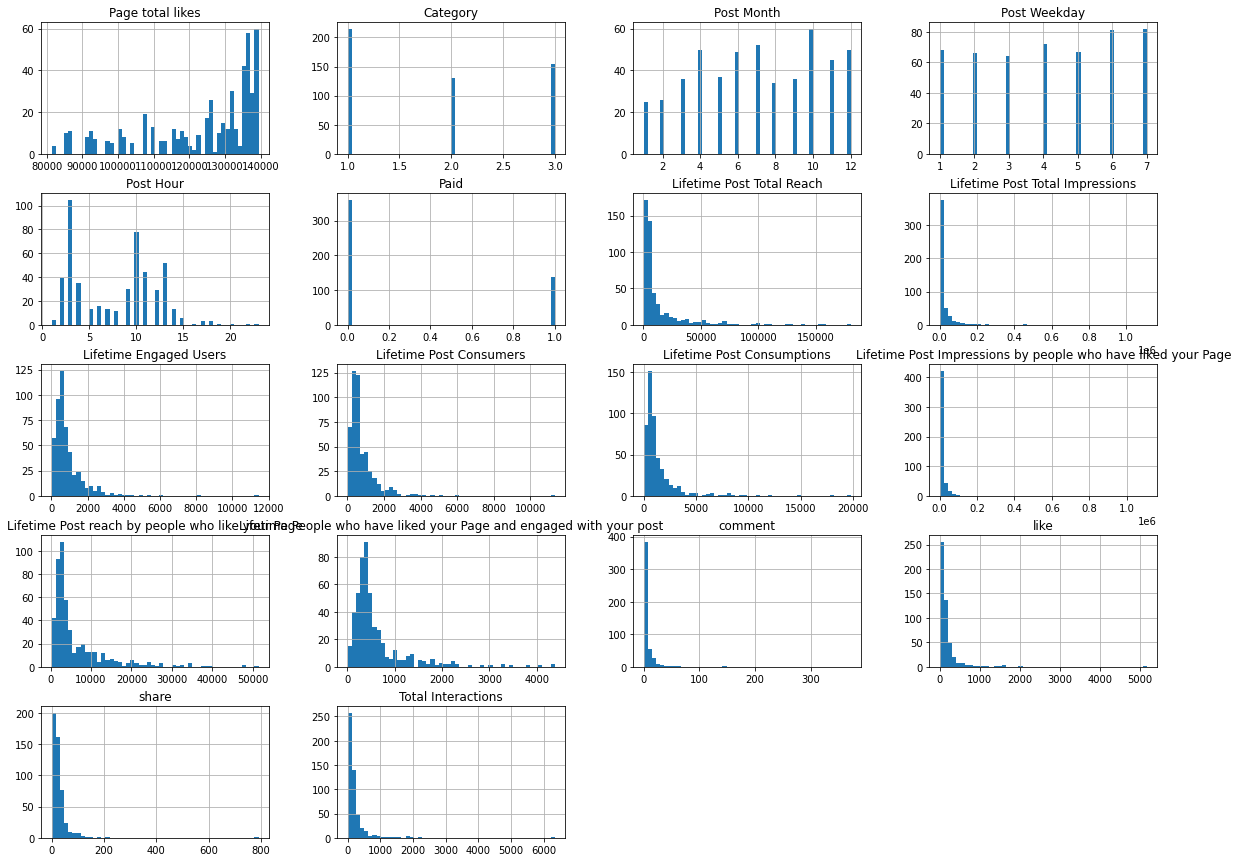

In [26]:
_ = df.hist(bins=50, figsize=(20,15))

In [27]:
# Create separate training and test sets. we'll use the training set for steps 3--6
train_set, test_set = train_test_split(df, test_size=0.2, random_state=23)  
# by setting a random_state above, we make sure anytime we run this line we end up with the same train and test sets
print(len(train_set), len(test_set))

400 100


In [28]:
# Let's make a copy of the training set to ensure we don't mess things up
df = train_set.copy()

In [29]:
features = ["Category", "Page total likes", "Type", "Post Month", "Post Hour", "Post Weekday", "Paid"]
df[features].head()

,Category,Page total likes,Type,Post Month,Post Hour,Post Weekday,Paid
61,1,138185,Photo,11,2,3,1.0
13,2,139441,Photo,12,3,5,0.0
183,1,134879,Video,9,10,2,0.0
38,2,138895,Status,12,9,7,0.0
479,3,86909,Photo,1,4,5,0.0


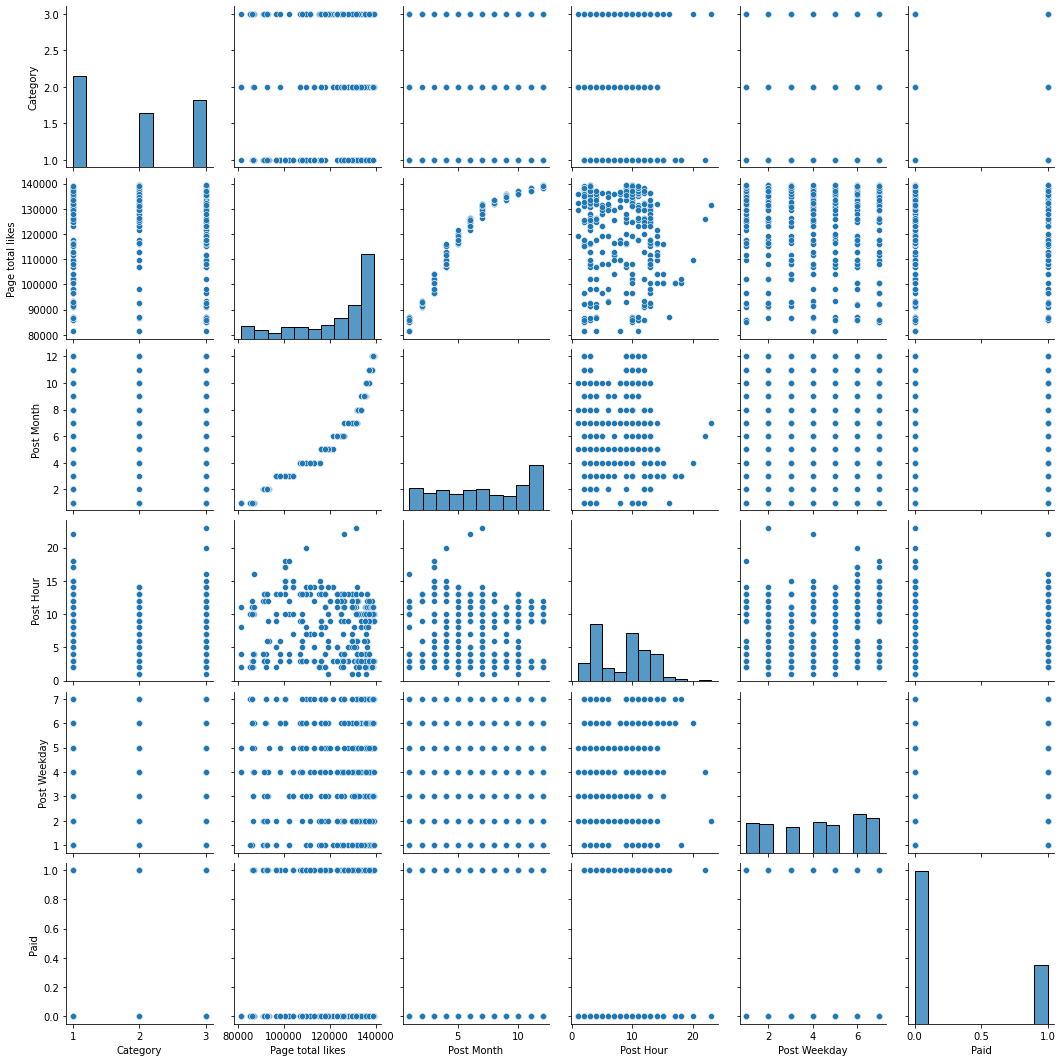

In [30]:
# Scatterplots
_ = sns.pairplot(df[features])
# An equivalent plot can be done with pandas:
#_ = pd.plotting.scatter_matrix(df[features], figsize=(12, 8))

In [31]:
# Correlations
correlations = df.corr()  # this is a dataframe
# let's see how much each attribute correlates with the outcome 'like'
correlations['like'].sort_values(ascending=False)

like                                                                   1.000000
Total Interactions                                                     0.997956
share                                                                  0.916424
comment                                                                0.856275
Lifetime Post reach by people who like your Page                       0.634616
Lifetime Engaged Users                                                 0.572801
Lifetime Post Total Reach                                              0.556006
Lifetime People who have liked your Page and engaged with your post    0.501722
Lifetime Post Consumers                                                0.351391
Lifetime Post Total Impressions                                        0.343128
Lifetime Post Impressions by people who have liked your Page           0.247382
Lifetime Post Consumptions                                             0.231878
Paid                                    

In [32]:
df = train_set.copy()
# Most algorithms cannot work with missing values. Three main ways to deal with them:
# 1. Drop rows
# 2. Drop features with NaNs
# 3. Fill missing values
# As we have very few missing values, let's drop the rows
print("Number of rows before dropping NaNs: %d" % len(df))
df = df.dropna()
print("Number of rows after dropping NaNs: %d" % len(df))
# Separate features from outcomes
y_df = df['like'].copy()
X_df = df[features].copy()

Number of rows before dropping NaNs: 400
Number of rows after dropping NaNs: 396


In [33]:
# We previously observed that some of the features were categorical. 
# Two main ways to deal with these: OrdinalEncoder() or OneHotEncoding()

# Let's use OneHotEncoding for the categories ('Category', 'Paid', 'Type')
# As we will later want to transform the test set, let's follow good practice and create a custom transformer for a sklearn pipeline

# This is an example of how it would be done. Since this is a very simple transformation, there's a better way of doing it
# using ColumnTransformer. We show it below

class OneHotEncoderCategoricalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features):
        self.cat_features = cat_features # cat_features are those column of features on which transformation is needed to be applied 
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):#  X is the data set which contains those columns , X_df = df[features].copy() 
        return pd.get_dummies(X, columns=self.cat_features)

In [34]:
cat_features = ["Category", "Type"]

encoder = OneHotEncoderCategoricalFeatures(cat_features)
X_oho = encoder.transform(X_df)
X_oho

,Page total likes,Post Month,Post Hour,Post Weekday,Paid,Category_1,Category_2,Category_3,Type_Link,Type_Photo,Type_Status,Type_Video
61,138185,11,2,3,1.0,1,0,0,0,1,0,0
13,139441,12,3,5,0.0,0,1,0,0,1,0,0
183,134879,9,10,2,0.0,1,0,0,0,0,0,1
38,138895,12,9,7,0.0,0,1,0,0,0,1,0
479,86909,1,4,5,0.0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
438,98195,3,6,6,0.0,0,1,0,1,0,0,0
457,92828,2,6,3,0.0,1,0,0,0,1,0,0
40,138895,12,11,6,0.0,0,1,0,0,0,1,0
230,131630,7,23,2,0.0,0,0,1,0,1,0,0


In [35]:
# Let's also look at standardising some of the numerical features
num_features = ['Page total likes']

# Use column transformer: numerical features will be standardised; categorical features will be transformed with OHO

# We can use a ColumnTransformer to transform only some types of columns in different ways
colTransformer = ColumnTransformer([
    ('num', StandardScaler(), num_features),     #(eachvalue - mean / standard deviation) 
    ('cat', OneHotEncoder(), cat_features)       # another way of doing transformation 
    ],
    remainder='passthrough'  # i.e., leave the rest of the columns untouched -- otherwise, they're dropped
    )

X_processed = colTransformer.fit_transform(X_df)
X_processed.shape

(396, 12)

In [36]:
X_processed[0,:]

array([ 0.90234462,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        , 11.        ,  2.        ,
        3.        ,  1.        ])

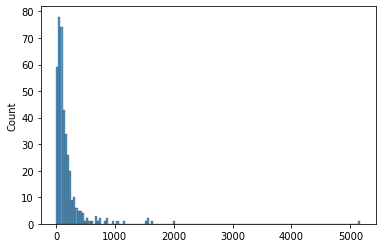

In [37]:
y = y_df.values
_ = sns.histplot(y, kde=False)

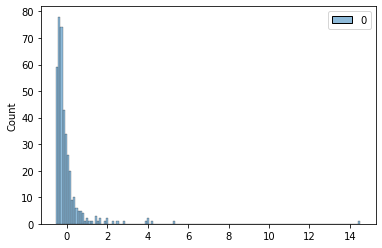

In [38]:
# Since the 'y' is skewed and the range is very large, we can also transform it
y_transformer = StandardScaler()  # we'll need this scaler for the test set later!
y = y_transformer.fit_transform(y.reshape(-1,1))
_ = sns.histplot(y, kde=False)

In [39]:
clf = DecisionTreeRegressor()  # Decision tree
clf.fit(X_processed, y)
print("MSE of the model = %1.4g" % mse(y, clf.predict(X_processed)))

MSE of the model = 0.0005276


In [40]:
n_test = 100
n_repeat = 1000

estimator = RandomForestRegressor()

# Compute predictions
y_predicts = np.ones((n_repeat, len(X_processed))) * np.nan #matrix of dimension 1000*396 is created 
for i in range(n_repeat):
    sample  = np.random.choice(range(len(X_processed)), replace=True, size=len(X_processed))  # bootstrap! # selects from values (0 to 396) and gives 396 outcomes  
    train_ids = sample[:-n_test] # copies elements of sample from index zero to index 296 in train ids 
    val_ids = sample[-n_test:] # copy elements of sample from index 296 to 396 in val_ids 
    val_ids = np.setdiff1d(val_ids, train_ids)  # only use those that weren't in the training set for testing # return those values of val_ids that were not in train_ids 
    if len(val_ids) == 0:
        continue
    X_train, y_train = X_processed[train_ids], y[train_ids] # X_train = 296 elements from X_processed are copied to X_train and indexes of those elements are in train_ids 
    X_val, y_val = X_processed[val_ids], y[val_ids]  # x_val is subset of X_processed of those values whose index was in val_ids
    
    estimator.fit(X_train, y_train.ravel())
    y_predict = estimator.predict(X_val) # returns y_predict of the same order as X_val 
    y_predicts[i, val_ids] = y_predict # on each row of y_predicts copy on the indexes (that are contained in val_ids) value of y_predict

In [43]:
y_bias = (y - np.nanmean(y_predicts, axis=0))**2
y_error = np.nanmean((y.T - y_predicts) **2, axis=0)
y_var = np.nanvar(y_predicts, axis=0, ddof = 1)

clf_type = "Random Forest"

print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          "+ {3:.4f} (var)".format(clf_type, np.nanmean(y_error), np.nanmean(y_bias), np.nanmean(y_var)))

print("{0}: {1:.4f} ((bias^2) + (var)) = {2:.4f} (bias^2) "
          "+ {3:.4f} (var)".format(clf_type, np.mean(y_bias) + np.mean(y_var), np.mean(y_bias), np.mean(y_var)))

Random Forest: 1.3438 (error) = 1.1633 (bias^2) + 0.2420 (var)
Random Forest: 1.4053 ((bias^2) + (var)) = 1.1633 (bias^2) + 0.2420 (var)


In [46]:
clf = RandomForestRegressor(n_estimators=1000,max_depth=2)
#clf = BayesianRidge(normalize=True)
scores = cross_val_score(clf, X_processed, y.ravel(), cv=10, scoring = make_scorer(mse))

dummy_clf = DummyRegressor(strategy='mean')
dummy_scores = cross_val_score(dummy_clf, X_processed, y.ravel(), cv=10, scoring = make_scorer(mse))

print("MSE: %0.8f +/- %0.8f" % (scores.mean(), scores.std()))
print("Dummy MSE: %0.8f +/- %0.8f" % (dummy_scores.mean(), dummy_scores.std()))

MSE: 1.00948177 +/- 1.58908580
Dummy MSE: 1.01257831 +/- 1.60295050


In [62]:
outcomes_of_interest = [ "Lifetime Post Consumers","like"]
n_bins = 20

y_df = df[outcomes_of_interest].copy()
y_df["like"], bins = pd.qcut(y_df["like"], n_bins, retbins=True)

outcomesLabelEncoder = LabelEncoder()
y_df['like'] = y_df['like'].apply(outcomesLabelEncoder.fit_transform)

y_df['id'] = range(1, len(df) + 1)

y_df.head()

,Lifetime Post Consumers,like,id
61,513,12,1
13,134,11,2
183,1956,17,3
38,5202,16,4
479,1078,7,5


In [63]:
X = X_processed  # Same we used for regression
y = y_df['like'].values.T

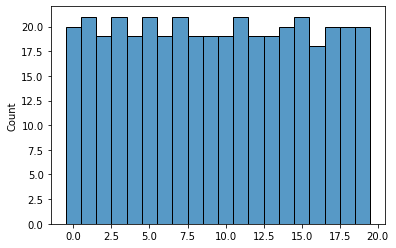

In [64]:
_ = sns.histplot(y, kde=False)

In [65]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_processed, y)
print("Dummy ACC: %.2f" % acc(y, dummy_clf.predict(X_processed)))

Dummy ACC: 0.06


In [66]:
clf = ExtraTreesClassifier(n_estimators=1000, max_depth=4)
scores = cross_val_score(clf, X_processed, y, cv=10, scoring=make_scorer(acc))  # cross-validation
print("ACC: %.2f +/- %.2f" % (scores.mean(), scores.std()))

ACC: 0.08 +/- 0.03


[ 1 10  8  0  9  4  5 11  6  3  2  7]
Feature ranking:
1. 1 (0.139766)
2. Post Weekday (0.137999)
3. Post Month (0.106899)
4. Page total likes (0.103778)
5. Post Hour (0.098544)
6. Link (0.094956)
7. Photo (0.064501)
8. Paid (0.063794)
9. Status (0.062987)
10. 3 (0.062856)
11. 2 (0.043653)
12. Video (0.020267)


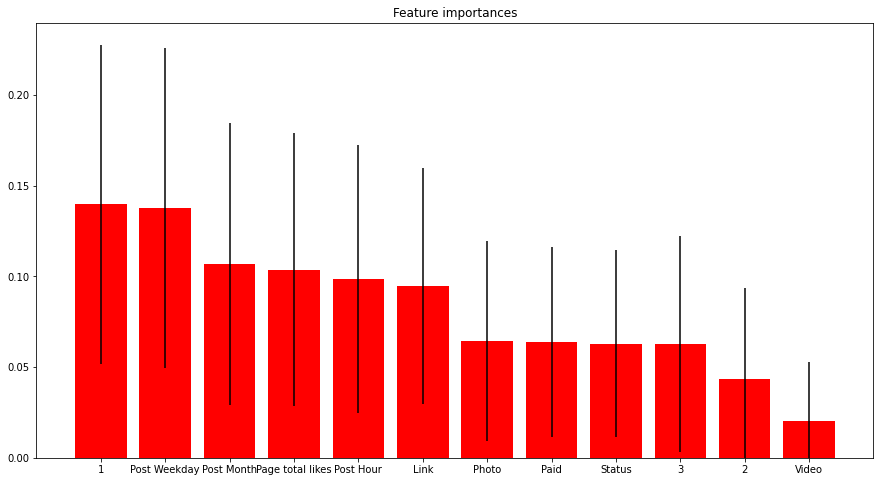

In [67]:
clf.fit(X_processed, y)

# Let's see the feature importances for our classifier
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print(indices)
# Let's get the attibute names:
extra_attribs = ['Post Month', 'Post Hour', 'Post Weekday', 'Paid']  # the ones we didn't modify in the transformer
cat_encoder = colTransformer.named_transformers_['cat']
cat_oho_attributes = oho_categories = [item for sublist in cat_encoder.categories_ for item in sublist]
feat_names = num_features + cat_oho_attributes + extra_attribs

# Print the feature ranking
print("Feature ranking:")
for f in range(X_processed.shape[1]):
    print("%d. %s (%f)" % (f + 1, feat_names[indices[f]],  importances[indices[f]]))

# Plot the feature importances of the forest
fig = plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(feat_names)[indices])
plt.xlim([-1, X.shape[1]])
plt.ylim([0, None])

fig.set_size_inches(15, 8)

In [68]:
# Get prediction on the test set
# Remember we need to do the same operations we did for the training test!
df_test = test_set.copy()
print('Size of test set: %d' % len(df_test))
# Drop rows with nans
df_test = df_test.dropna()
print("Number of rows after dropping NaNs: %d" % len(df_test))

Size of test set: 100
Number of rows after dropping NaNs: 99


In [69]:
# Separate features from outcomes
y_test_df = df_test[outcomes_of_interest].copy()
X_test_df = df_test[features].copy()
# Transform features
X_test = colTransformer.transform(X_test_df)
assert X_test.shape[1] == X_processed.shape[1]  # same number of features

In [70]:
# Make y into categories
y_test_df['like'] = pd.cut(y_test_df['like'], bins=bins, include_lowest=True)  # the bins previously returned by pd.qcut()
y_test_df['like'] = outcomesLabelEncoder.transform(y_test_df['like'])
y_test = y_test_df.values.T[1]  # lifetime post consumers
print (y_test)

[11  3 16  2 17  3 15  5  1  3 15 13  0  6 11 10  2  8 14  4 12  0  9  9
 12 18  1  0  6 13 11 10  4 14 15  8  4  6  3  4 19 10  3 14 11 12  9 10
  0  7 11  7 12 18  3 19 14 19 10 12 13  8  0  5  7  1 10  6 14 17 14 12
  1  6 15  4 16 13 16  6 15 19  7 18 15  3  4  1  2 15  1 11  3  7 14  9
  6 16 12]


In [71]:
# Predict
test_predictions = clf.predict(X_test)
# What's the accuracy on the test set?
acc(y_test, test_predictions)

0.08080808080808081

In [72]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        t = "(%.2f)"%(cm[i, j])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


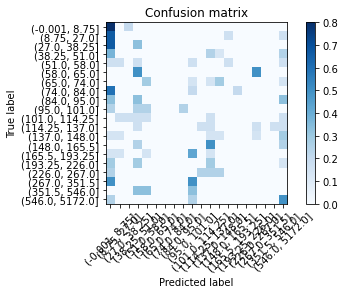

In [73]:
c = confusion_matrix(y_test, test_predictions)
plot_confusion_matrix(c, outcomesLabelEncoder.classes_)